In [1]:
import pandas as pd
import sklearn.tree as Tree;
import matplotlib.pyplot as plt
import warnings;warnings.filterwarnings("ignore");


In [2]:
# parameters controlling the complexity of the trees (max_depth = 5 is hidden)
impurity = 0.001
alpha = 0.001
window_sizes = [2*60,5*60] #window sides, in seconds

In [3]:
image_folder_path = "C:/Users/louis/github_vs/MA2---Towards-real-time-support-for-a-suicide-prevention-hotline-operators-"

df_all = pd.read_csv(image_folder_path+'/df_all_prechat.tsv', sep='\t')
df_all.drop(['id'],axis=1,inplace=True)


In [4]:
cols = ['postive','negative','user_handle','sec_since_start','event_id',
        'Labeling and mislabeling', 'Catastrophizing',
       'Dichotomous Reasoning', 'Emotional Reasoning',
       'Disqualifying the Positive', 'Magnification and Minimization',
       'Mental Filtering', 'Mindreading', 'Fortune-telling',
       'Overgeneralizing', 'Personalizing','Should statements']
df_all =df_all[cols]

In [5]:
df_all

,postive,negative,user_handle,sec_since_start,event_id,Labeling and mislabeling,Catastrophizing,Dichotomous Reasoning,Emotional Reasoning,Disqualifying the Positive,Magnification and Minimization,Mental Filtering,Mindreading,Fortune-telling,Overgeneralizing,Personalizing,Should statements
0,1.0,6.875,employee,11.0,cl000000,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,6.875,client,43.0,cl000000,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,6.875,employee,76.0,cl000000,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,6.875,client,91.0,cl000000,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,6.875,client,117.0,cl000000,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075237,3.0,5.375,employee,2592.0,cl024853,0,0,0,0,0,0,0,0,0,0,0,0
2075238,3.0,5.375,employee,2613.0,cl024853,0,0,0,0,0,0,0,0,0,0,0,0
2075239,3.0,5.375,employee,2621.0,cl024853,0,0,0,0,0,0,0,0,0,0,0,0
2075240,3.0,5.375,client,2648.0,cl024853,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:

all_trees =[]
states= ['postive','negative']
users = ['client','employee']

for w in window_sizes:
    
    w_df = df_all[df_all['sec_since_start']<w] #taking the first messages of the conversation
    w_df.loc[:,'sec_since_start'] = 1
    w_df.rename(columns = {'sec_since_start':'nb messages'}, inplace = True) # variable 'sec_since_start' is reused into a variable counting the number of messages 


    for i,state in enumerate(states):
                
        print("state: "+state)   
                        
        user_goups = w_df.groupby(['user_handle'])
        
        for name, user_group in user_goups:
            
            print('user = ',name)
            
            Y = user_group[[state,'event_id']].groupby('event_id').max() # the state should be the same for all the messages in a conversation, thus .max() returns the unique state of the conversation
            X = user_group.drop(states, axis=1).groupby('event_id').sum() # aggregation function, summing all the cds category per conversation, note that sum('nb messages') will count the number of messages contained in the conversation
            
            tree_model = Tree.DecisionTreeRegressor(max_depth = 5,min_impurity_decrease=impurity,ccp_alpha=alpha,criterion='absolute_error')
            tree_model.fit(X, Y)
            accuracy = tree_model.score(X,Y) # computing the score of the tree TODO why are they negative scores?
            
            all_trees.append((w,tree_model,accuracy,state,name))
            
            print("-------------------------------------------------------")

                    


state: postive
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------
state: negative
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------
state: postive
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------
state: negative
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------


window = 2.0 mins, state = postive user = client
score: -0.22068956618402003
window = 2.0 mins, state = postive user = employee
score: -0.09058759203285827
window = 2.0 mins, state = negative user = client
score: -0.04967434062949794
window = 2.0 mins, state = negative user = employee
score: -0.0665168320480003
window = 5.0 mins, state = postive user = client
score: -0.2047360164518568
window = 5.0 mins, state = postive user = employee
score: -0.13823328225174847
window = 5.0 mins, state = negative user = client
score: -0.044275993545866976
window = 5.0 mins, state = negative user = employee
score: -0.002081366325705769


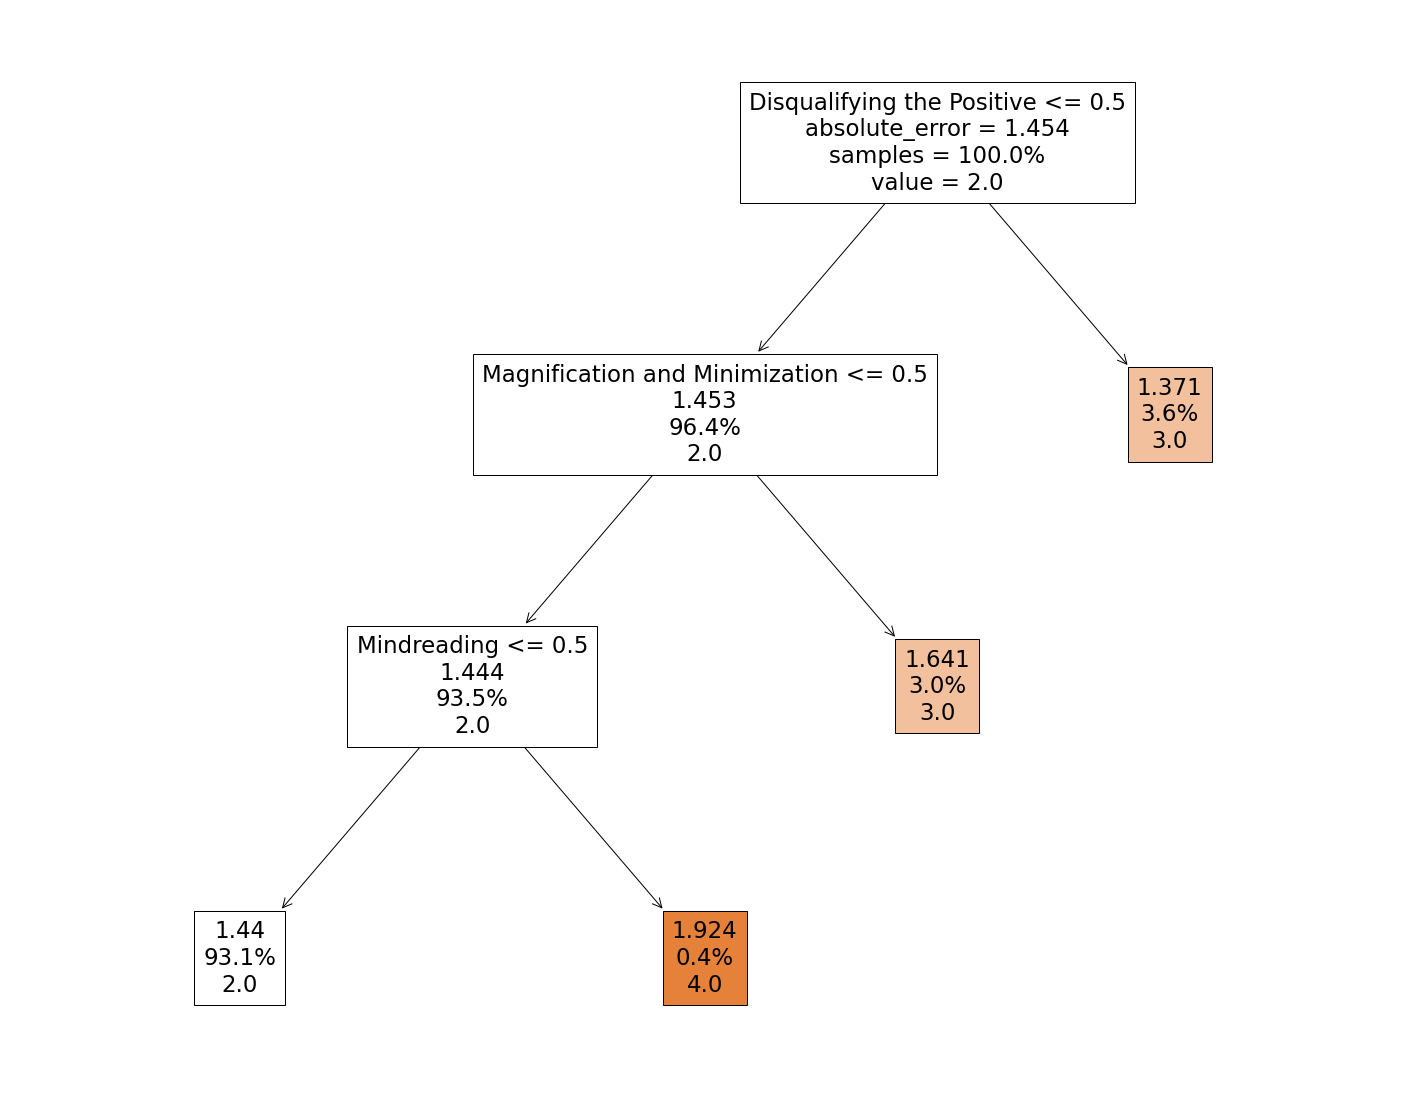

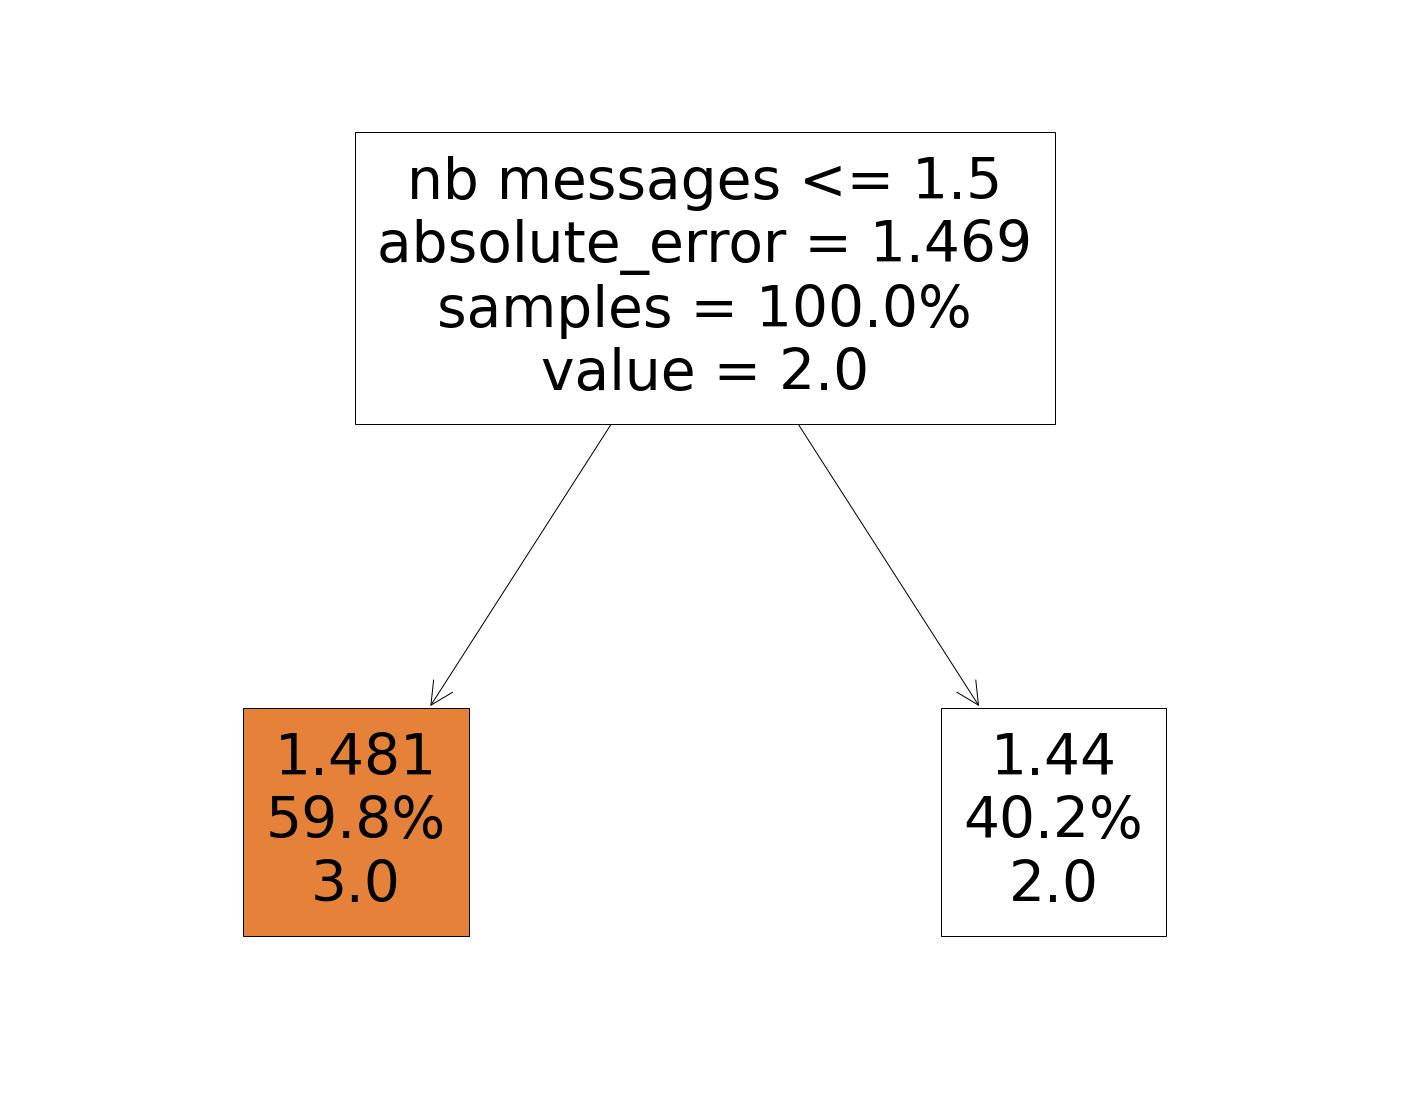

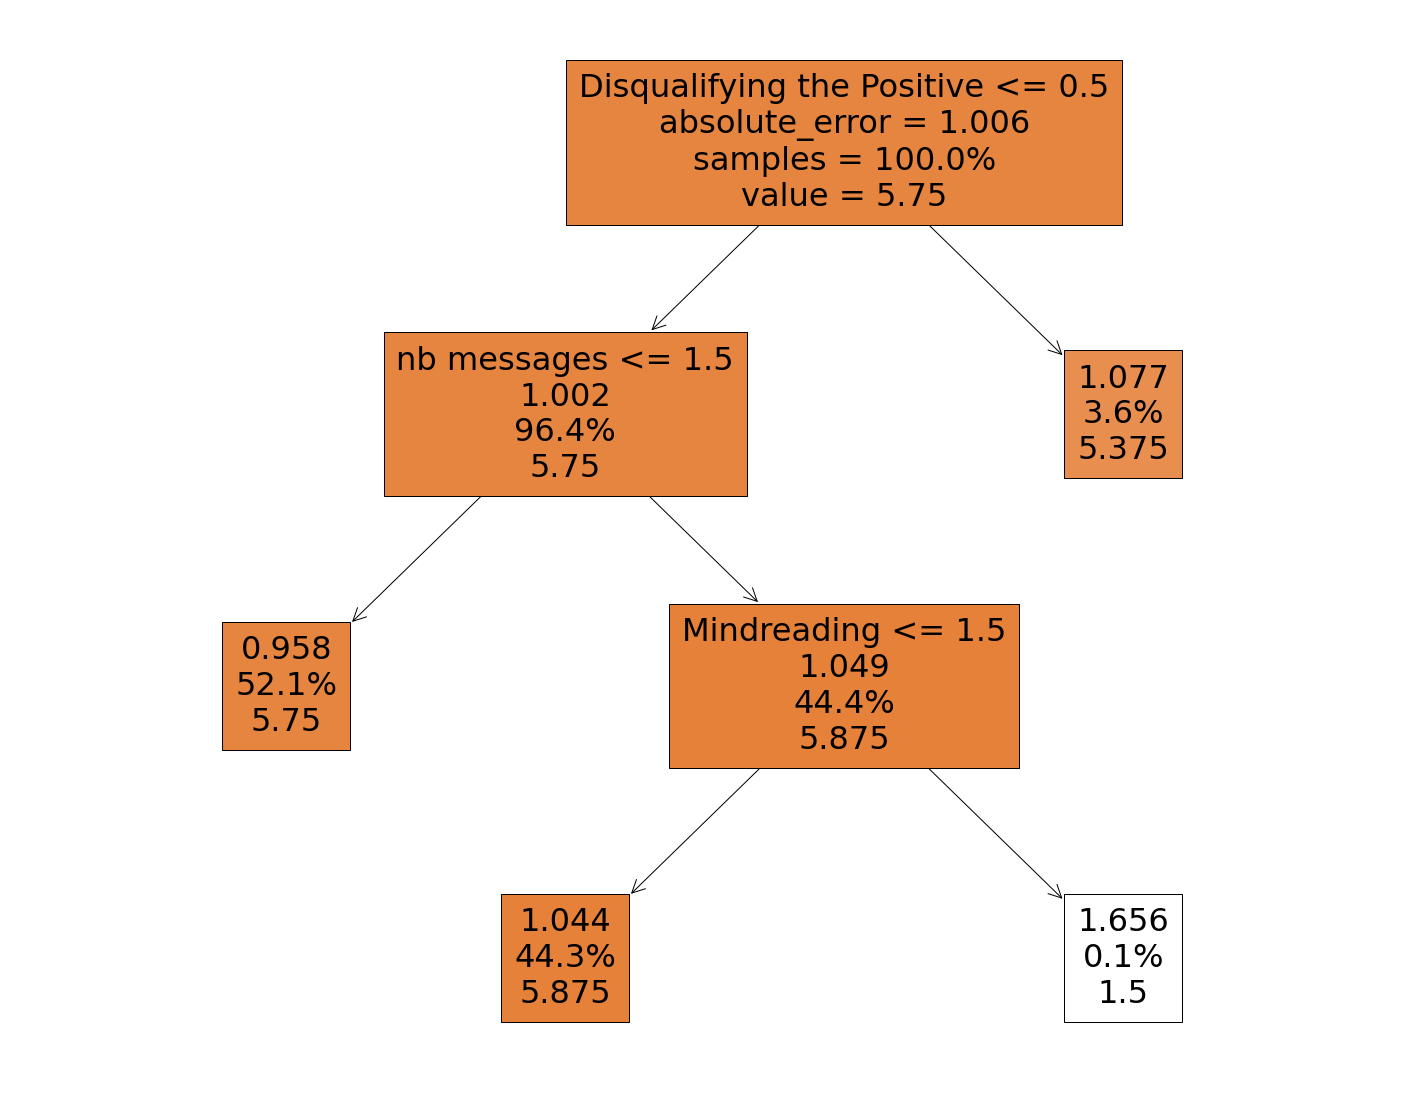

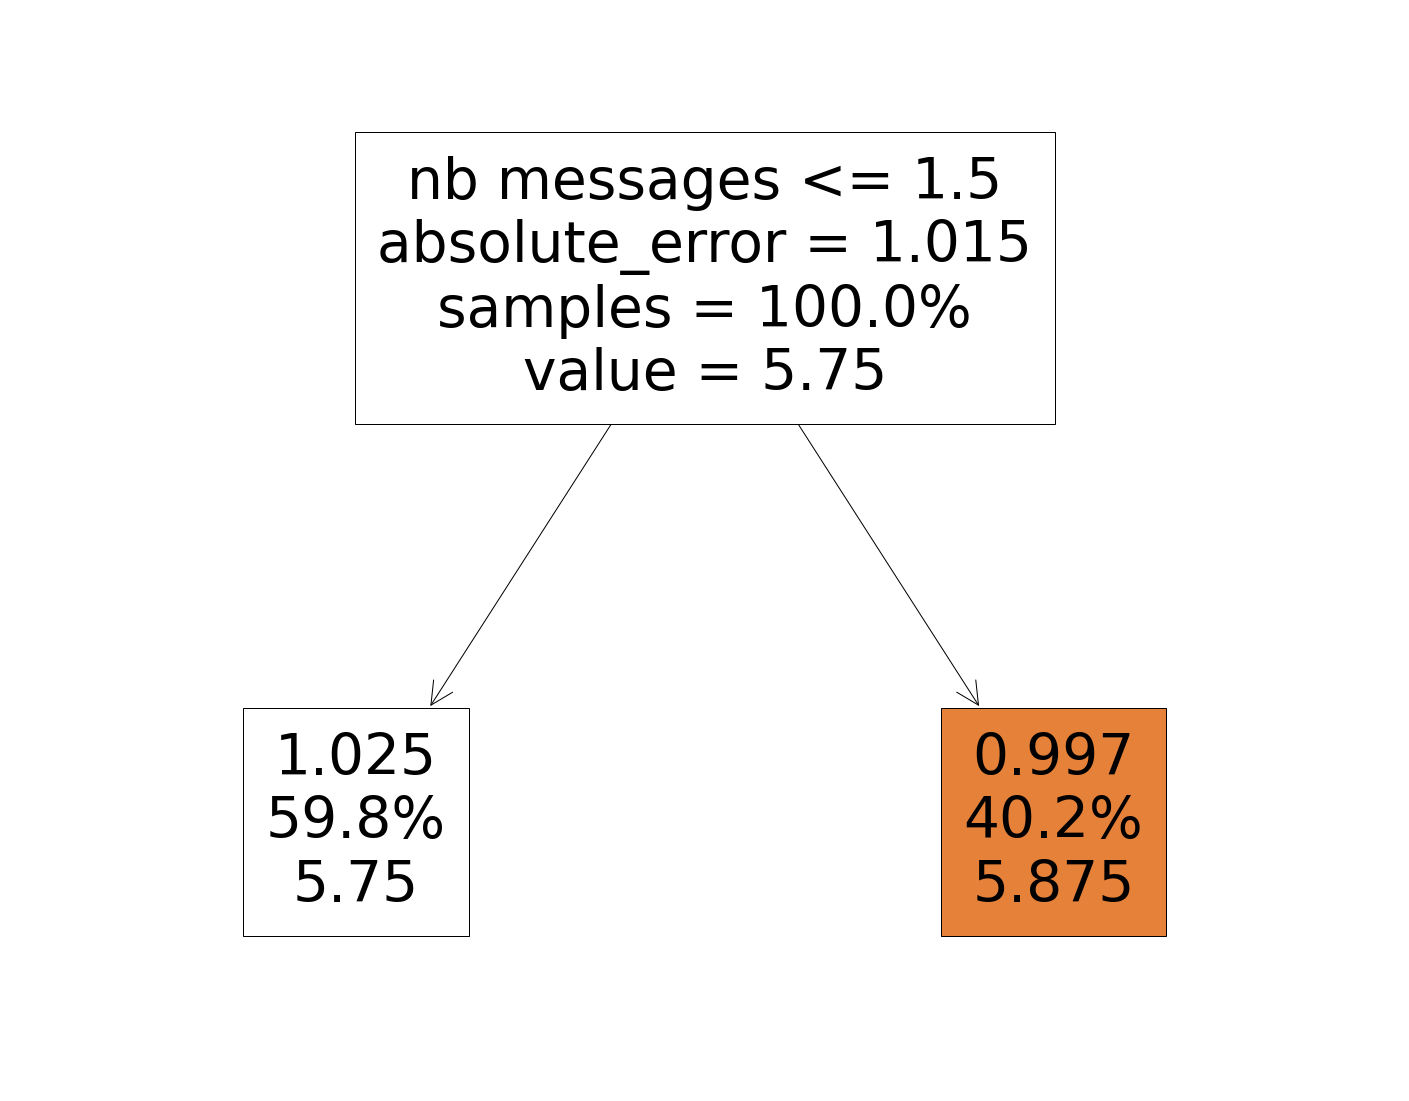

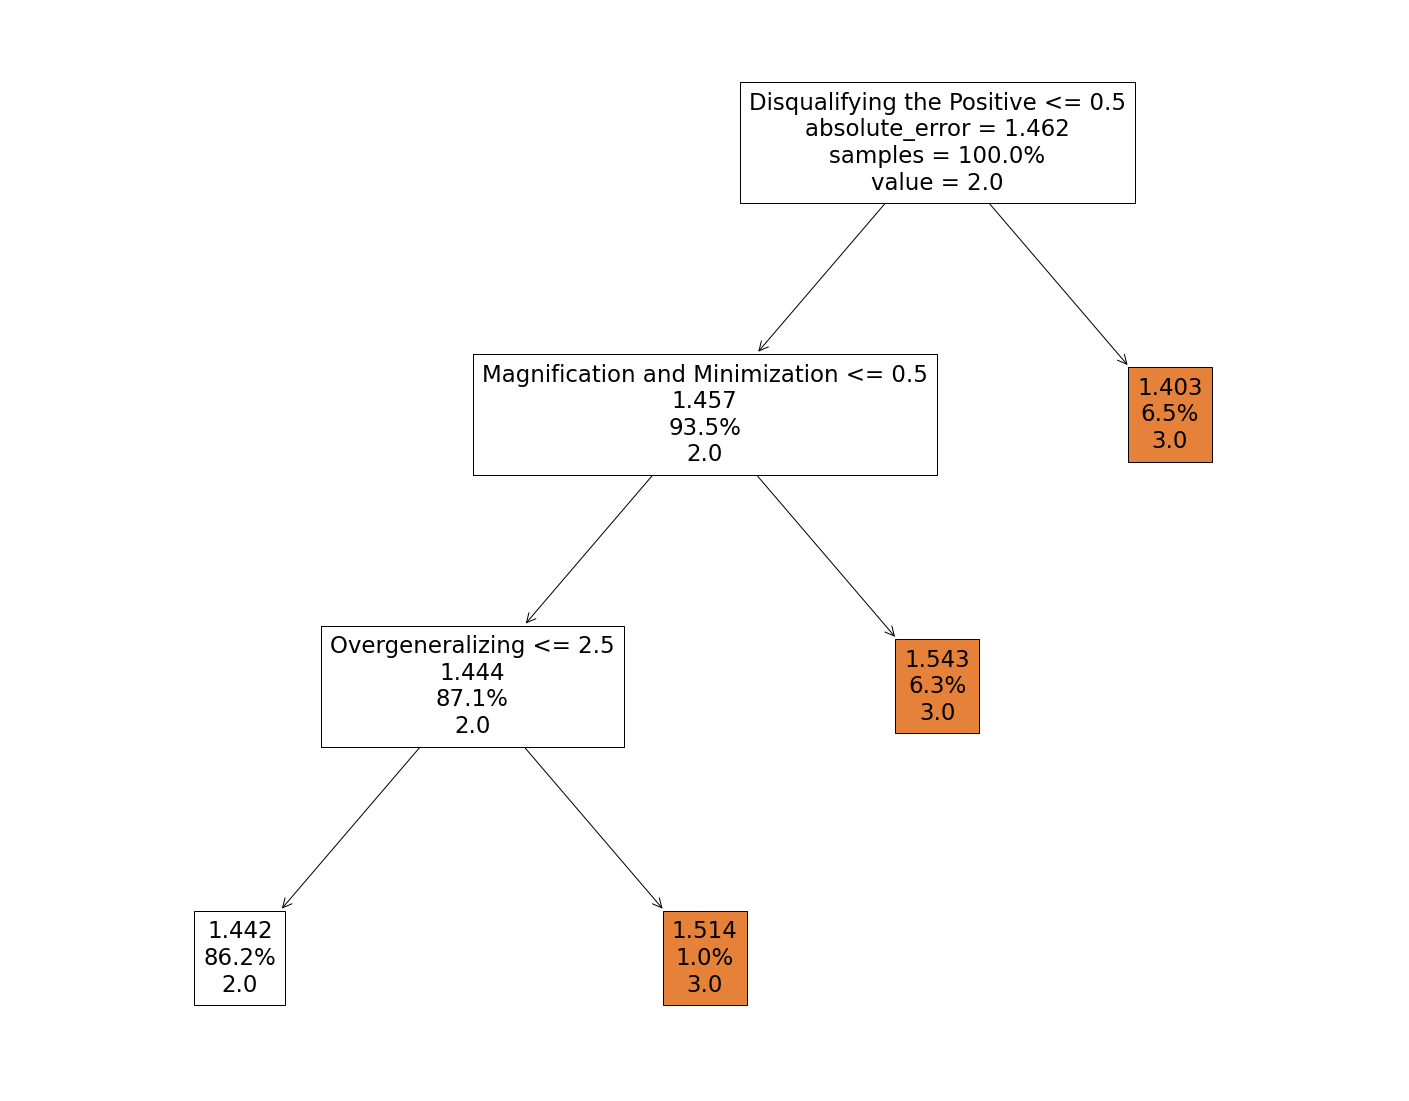

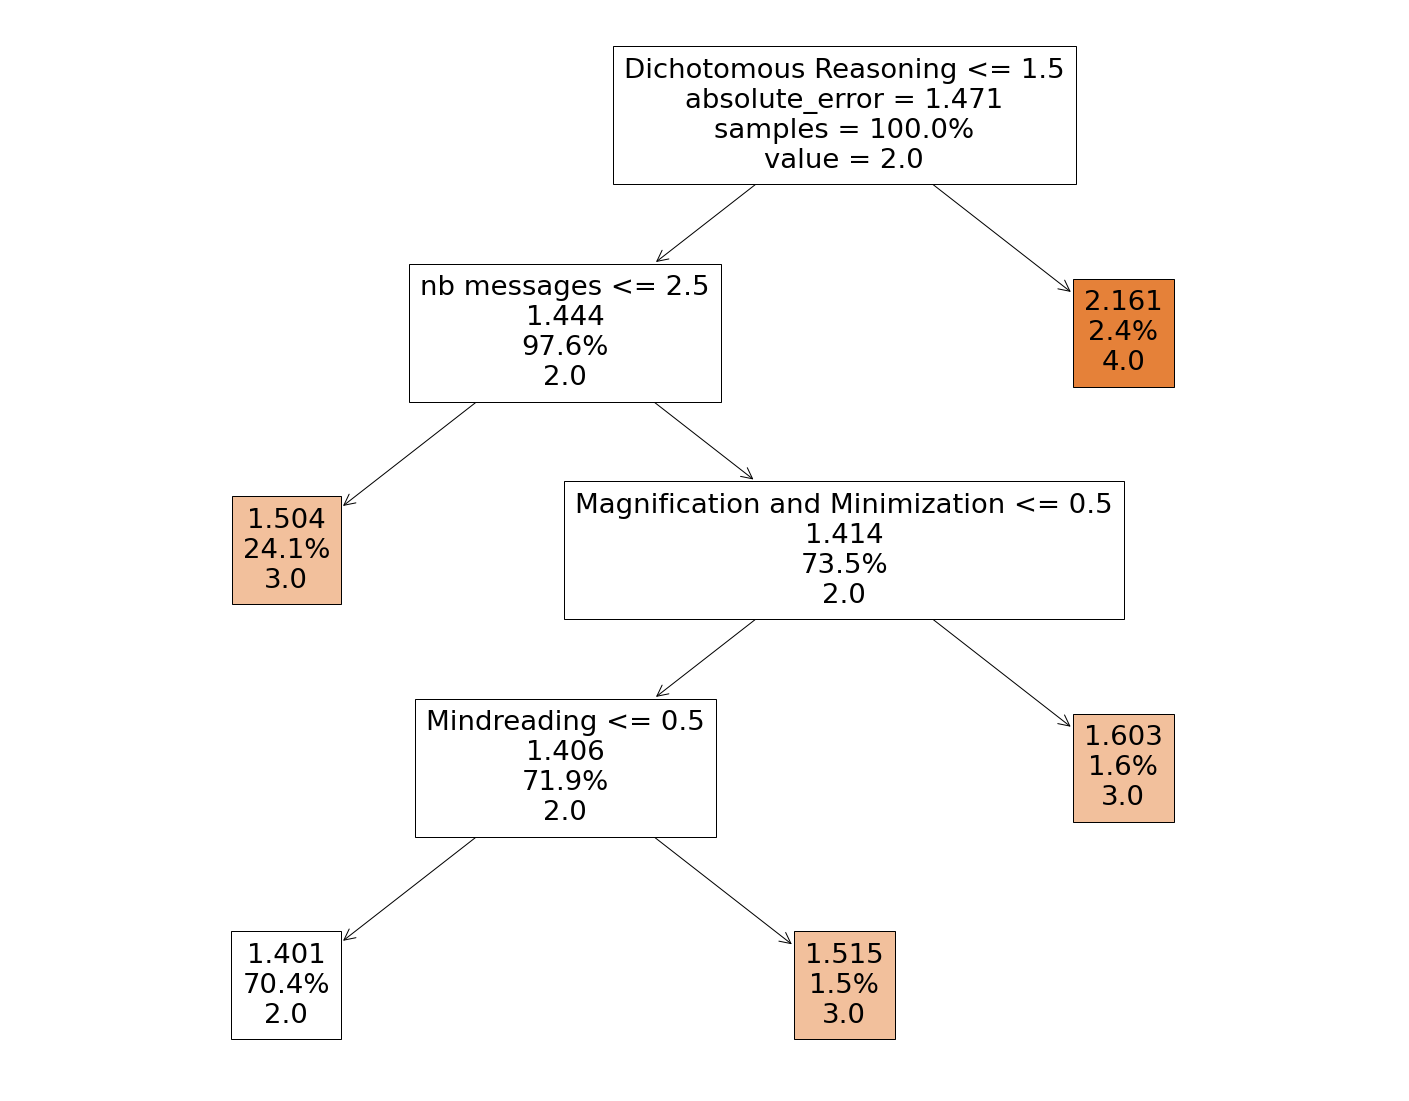

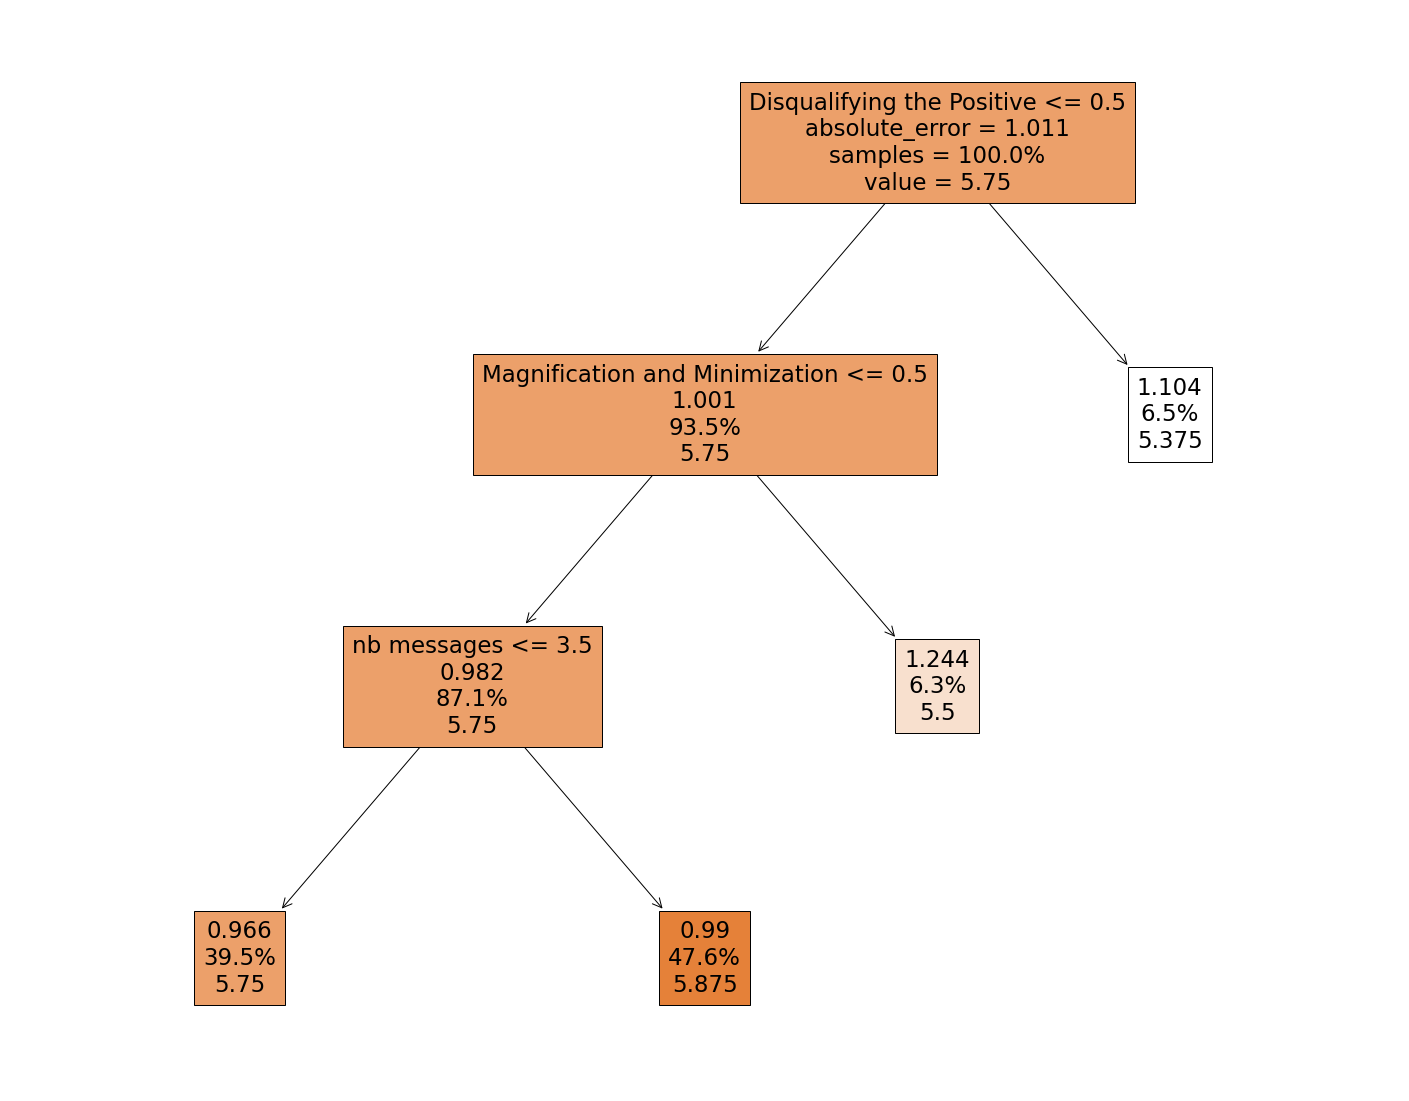

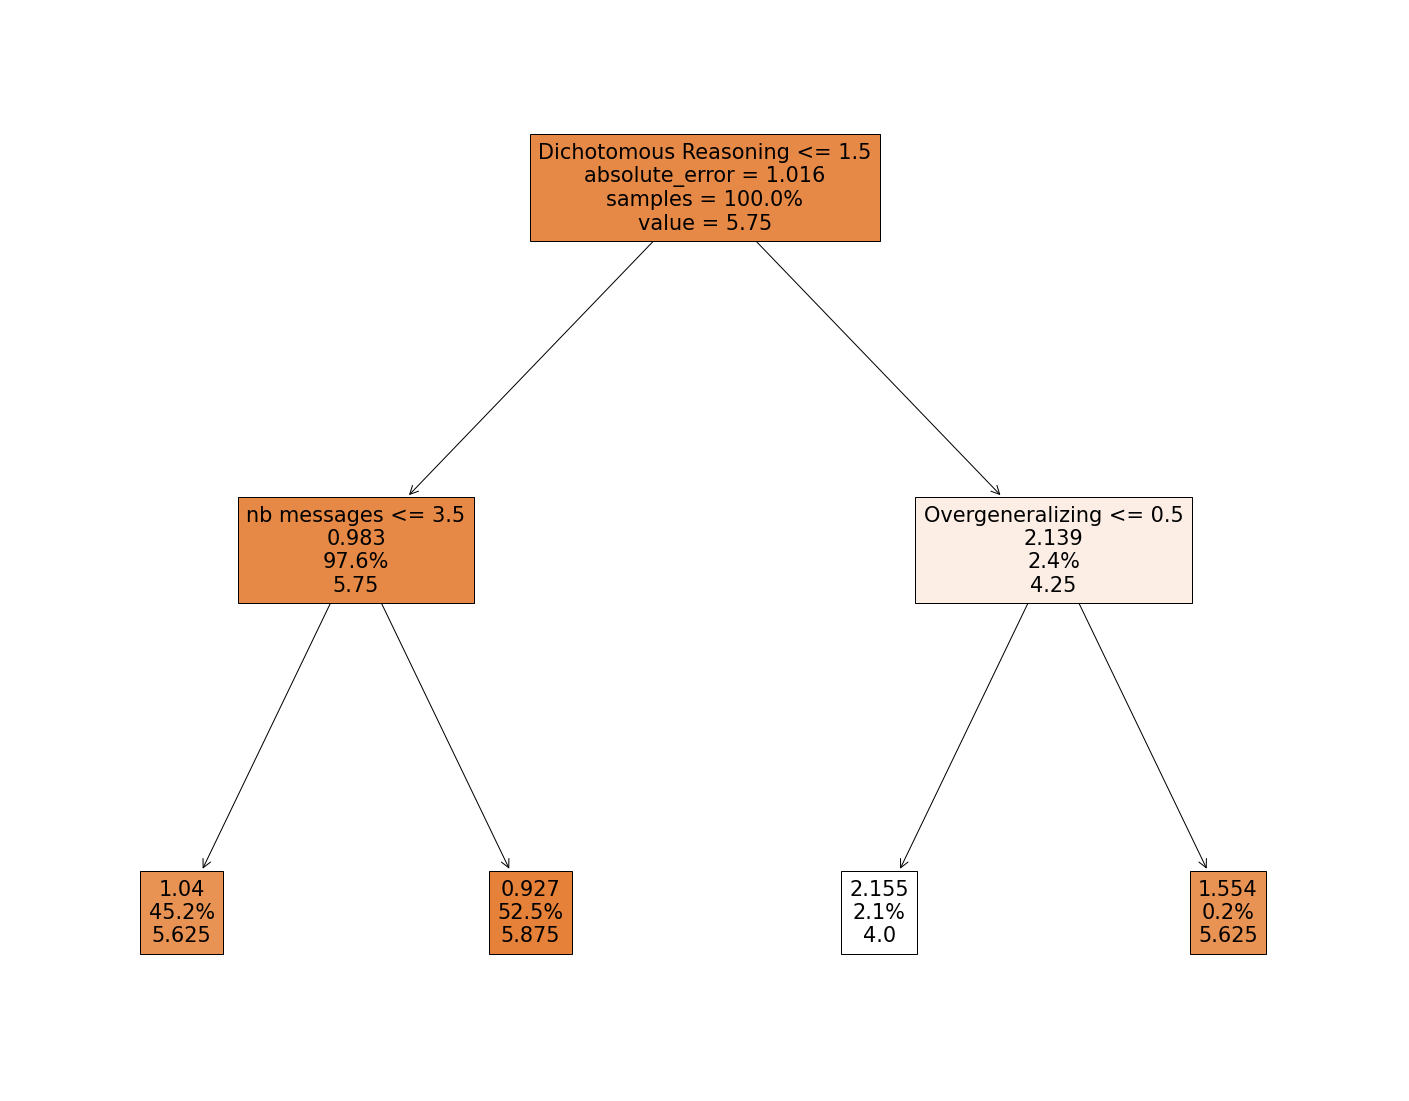

In [7]:
def plot_tree(all_trees):
    features = df_all.columns.drop(['postive',	'negative',	'user_handle',	'event_id']).to_list()
    features[0] = 'nb messages' # variable 'sec_since_start' has been reused into a variable counting the number of messages   

    for w,model,accuracy,state,user in all_trees:
        print("window =",w/60,'mins, state =',state,'user =',user)
        print("score:",accuracy)
        fig = plt.figure(figsize=(25,20))
        Tree.plot_tree(model, feature_names=features, filled = True, label='root',proportion=True)

plot_tree(all_trees)

In [8]:
# same as above but for the end of the conversations, using the POSTchat questions as target values

df_all = pd.read_csv(image_folder_path+'/df_all_postchat.tsv', sep='\t')
df_all.drop(['id'],axis=1,inplace=True)
df_all =df_all[cols]

all_trees =[]

for w in window_sizes:
    
    max = df_all.groupby("event_id").transform("max")['sec_since_start']

    w_df = df_all[df_all['sec_since_start']>max-w] #here we select the last messages in the conversation
    w_df.loc[:,'sec_since_start'] = 1
    w_df.rename(columns = {'sec_since_start':'nb messages'}, inplace = True)

    for i,state in enumerate(states):
        
                    
        print("state: "+state)   
                        
        user_goups = w_df.groupby(['user_handle'])
        
        for name, user_group in user_goups:
            
            print('user = ',name)
            
            Y = user_group[[state,'event_id']].groupby('event_id').max()
            X = user_group.drop(states, axis=1).groupby('event_id').sum()
            
            tree_model = Tree.DecisionTreeRegressor(max_depth = 5,min_impurity_decrease=impurity,ccp_alpha=alpha,criterion='absolute_error')
            tree_model.fit(X, Y)
            accuracy = tree_model.score(X,Y)
            
            all_trees.append((w,tree_model,accuracy,state,name))
            
            print("-------------------------------------------------------")

                    


state: postive
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------
state: negative
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------
state: postive
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------
state: negative
user =  client
-------------------------------------------------------
user =  employee
-------------------------------------------------------


window = 2.0 mins, state = postive user = client
score: -0.024738029430790176
window = 2.0 mins, state = postive user = employee
score: -0.03414633514721244
window = 2.0 mins, state = negative user = client
score: 0.01582088875036658
window = 2.0 mins, state = negative user = employee
score: 0.009553680138125631
window = 5.0 mins, state = postive user = client
score: -0.03243626634432295
window = 5.0 mins, state = postive user = employee
score: -0.02947832055099231
window = 5.0 mins, state = negative user = client
score: 0.021898524122654806
window = 5.0 mins, state = negative user = employee
score: 0.01861682420538746


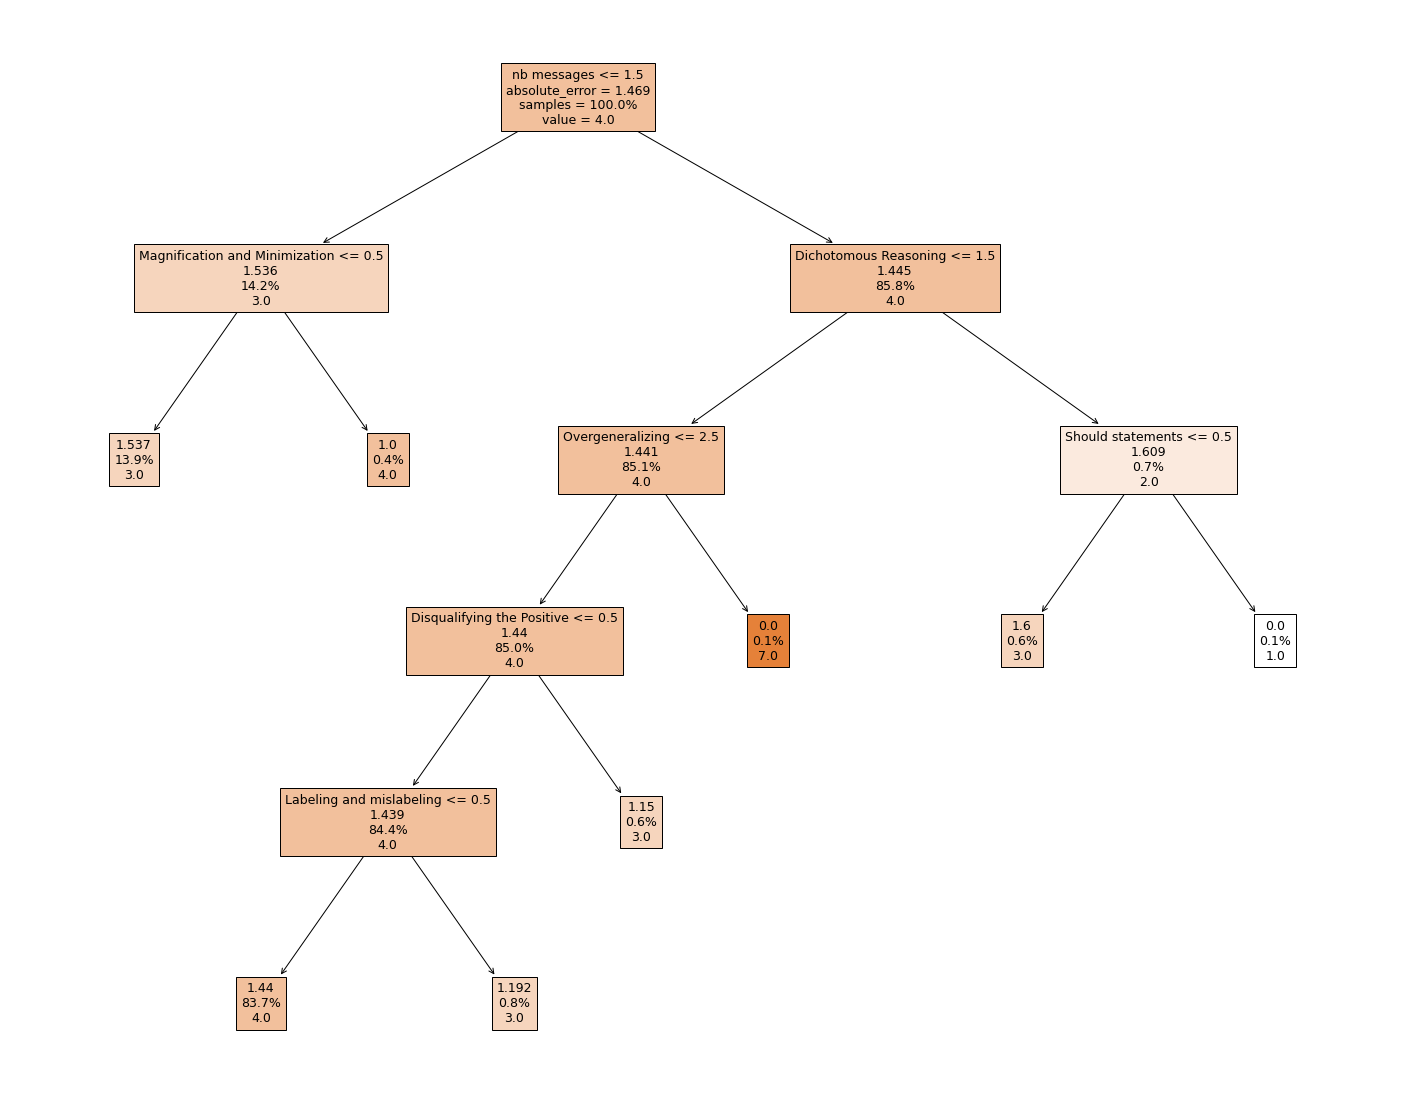

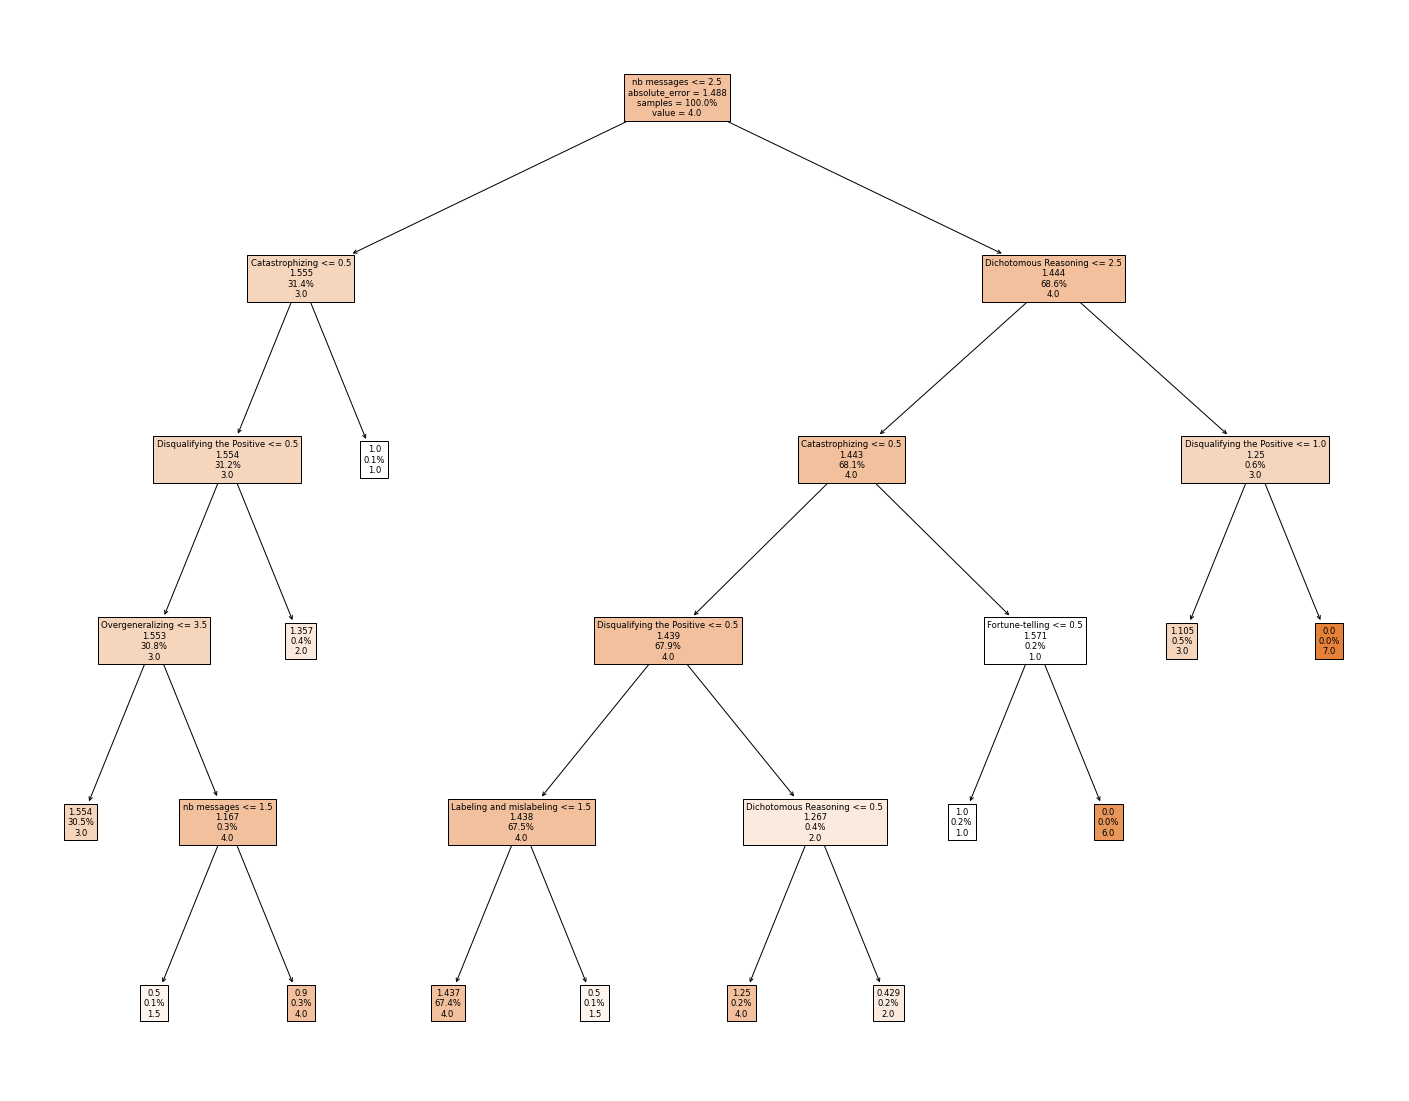

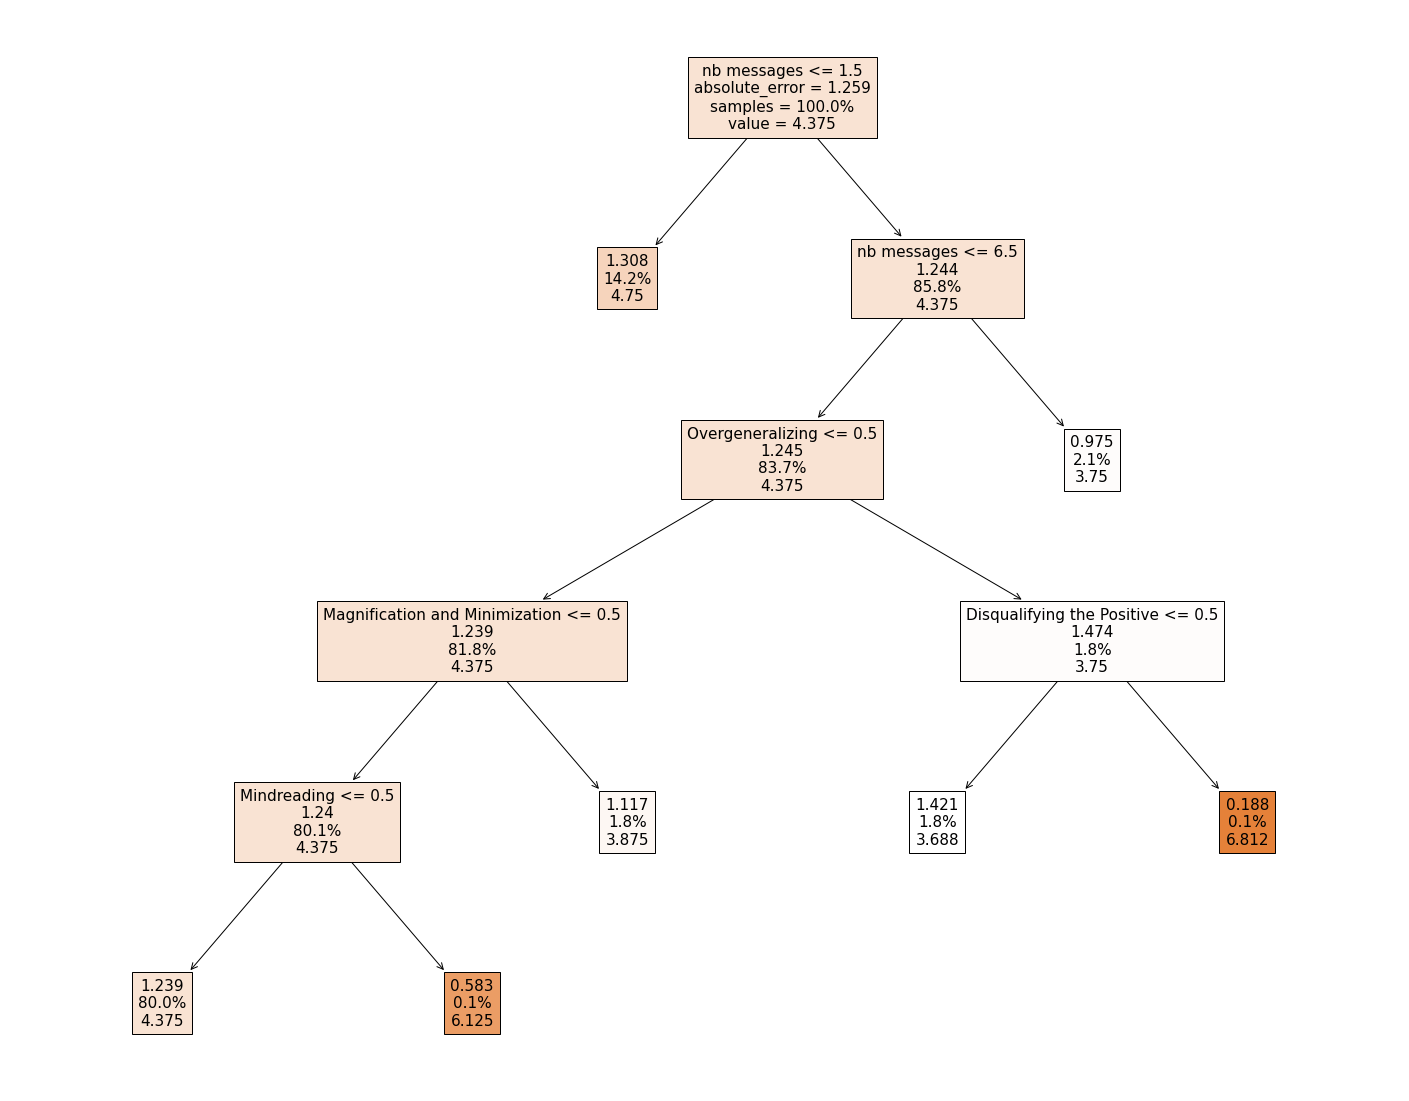

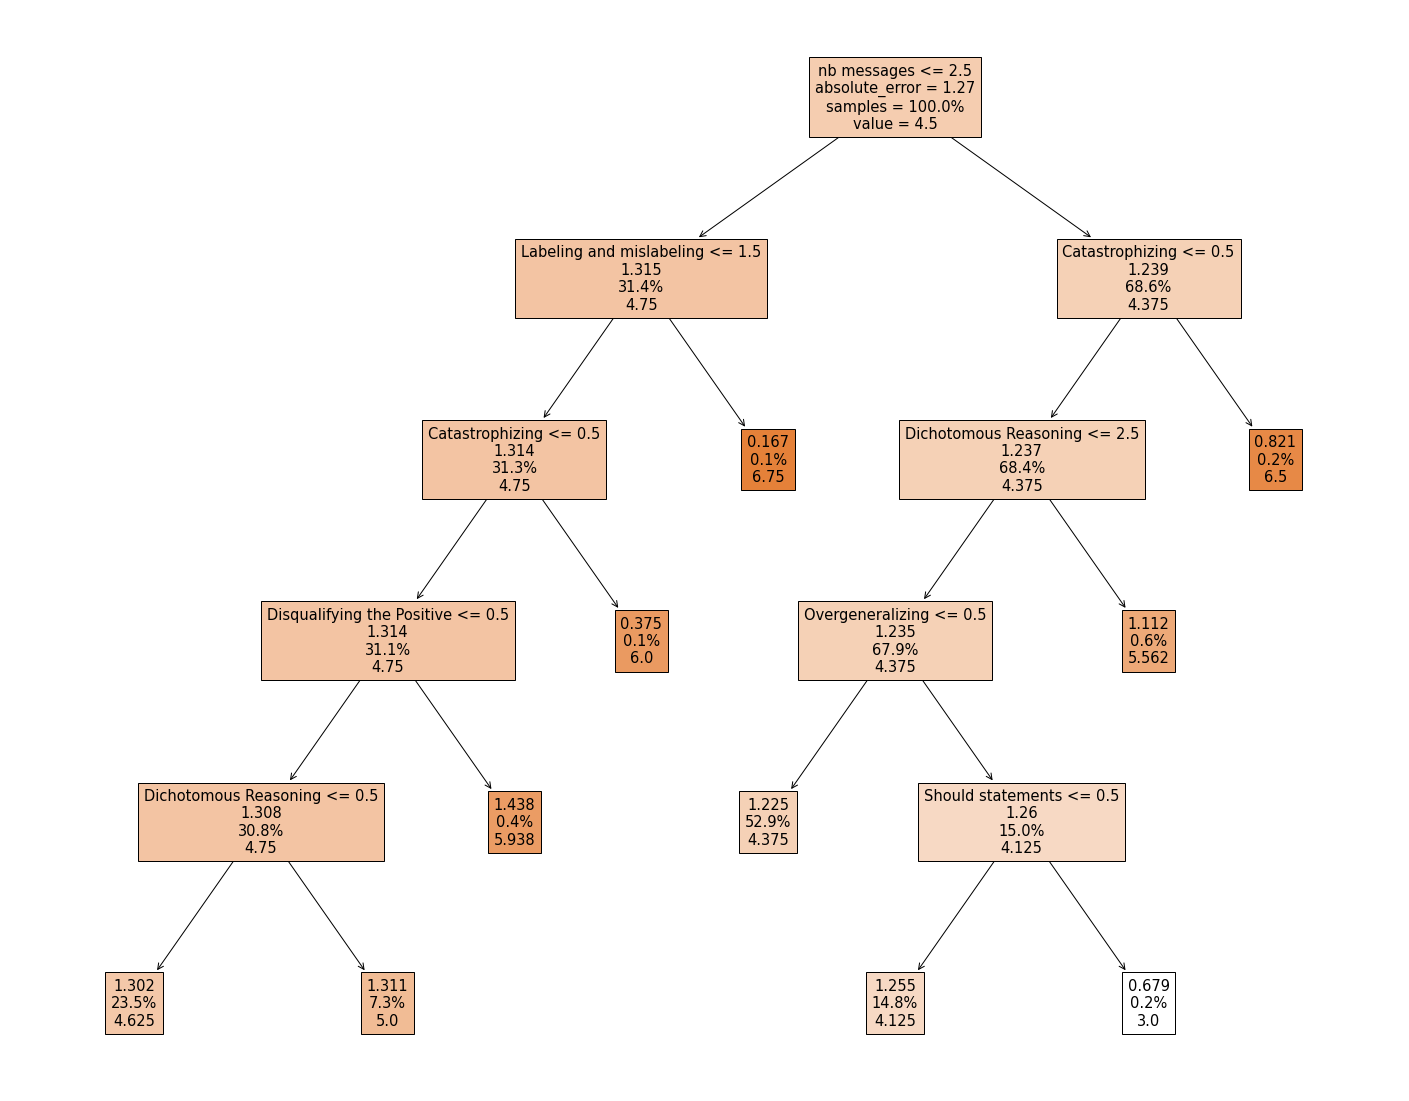

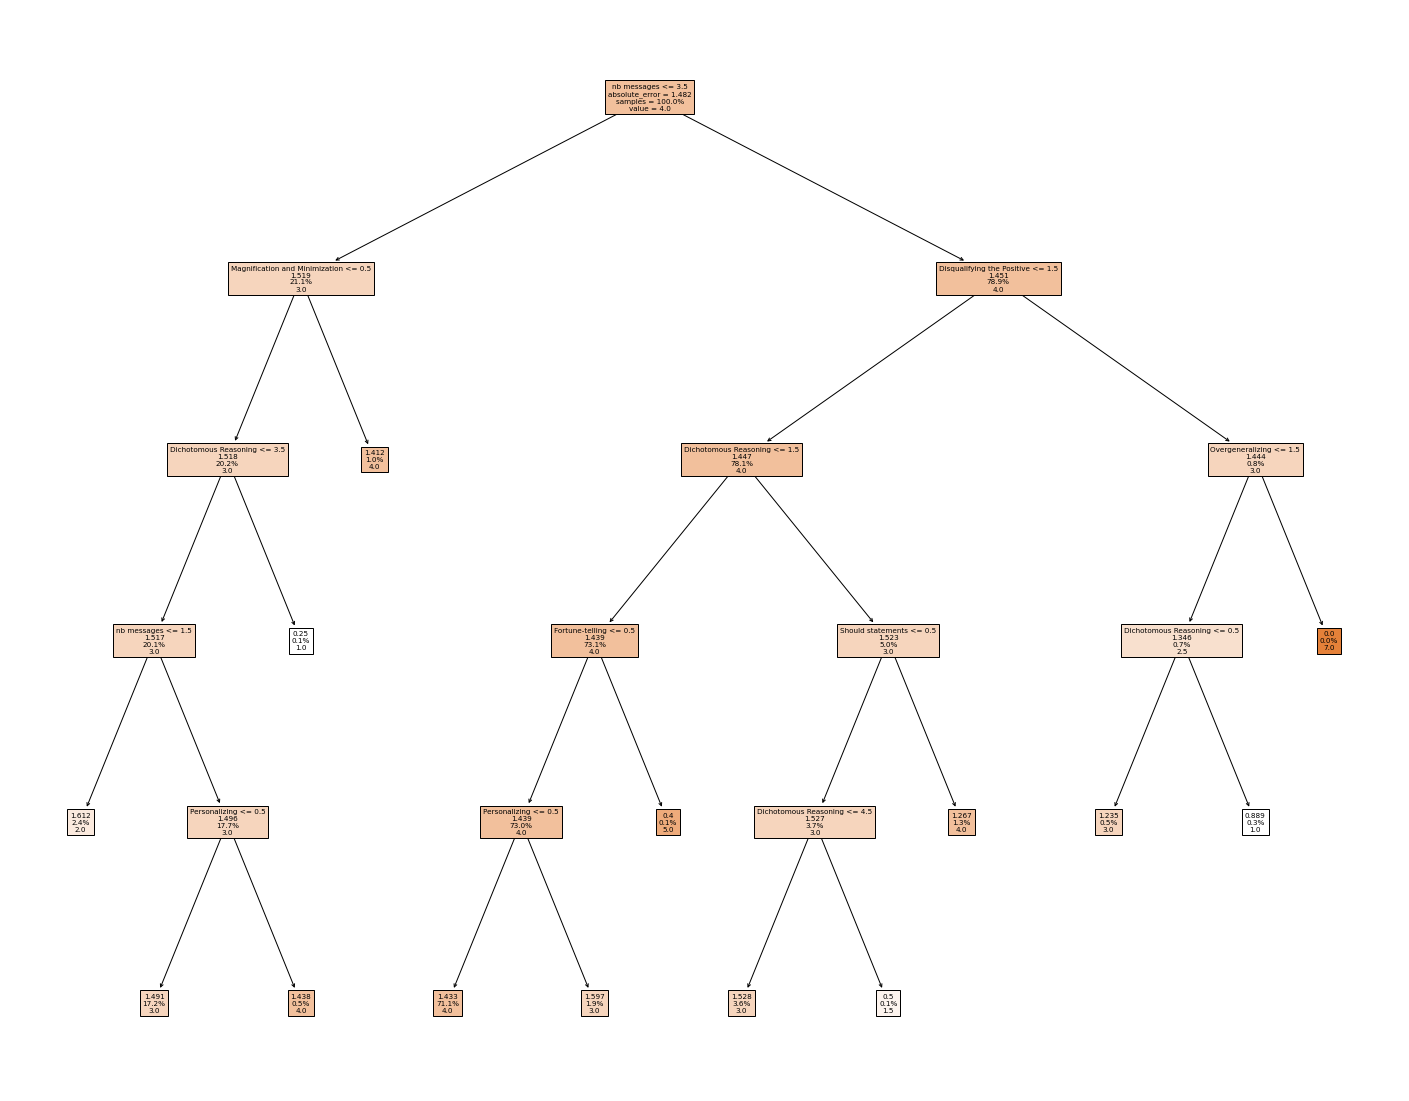

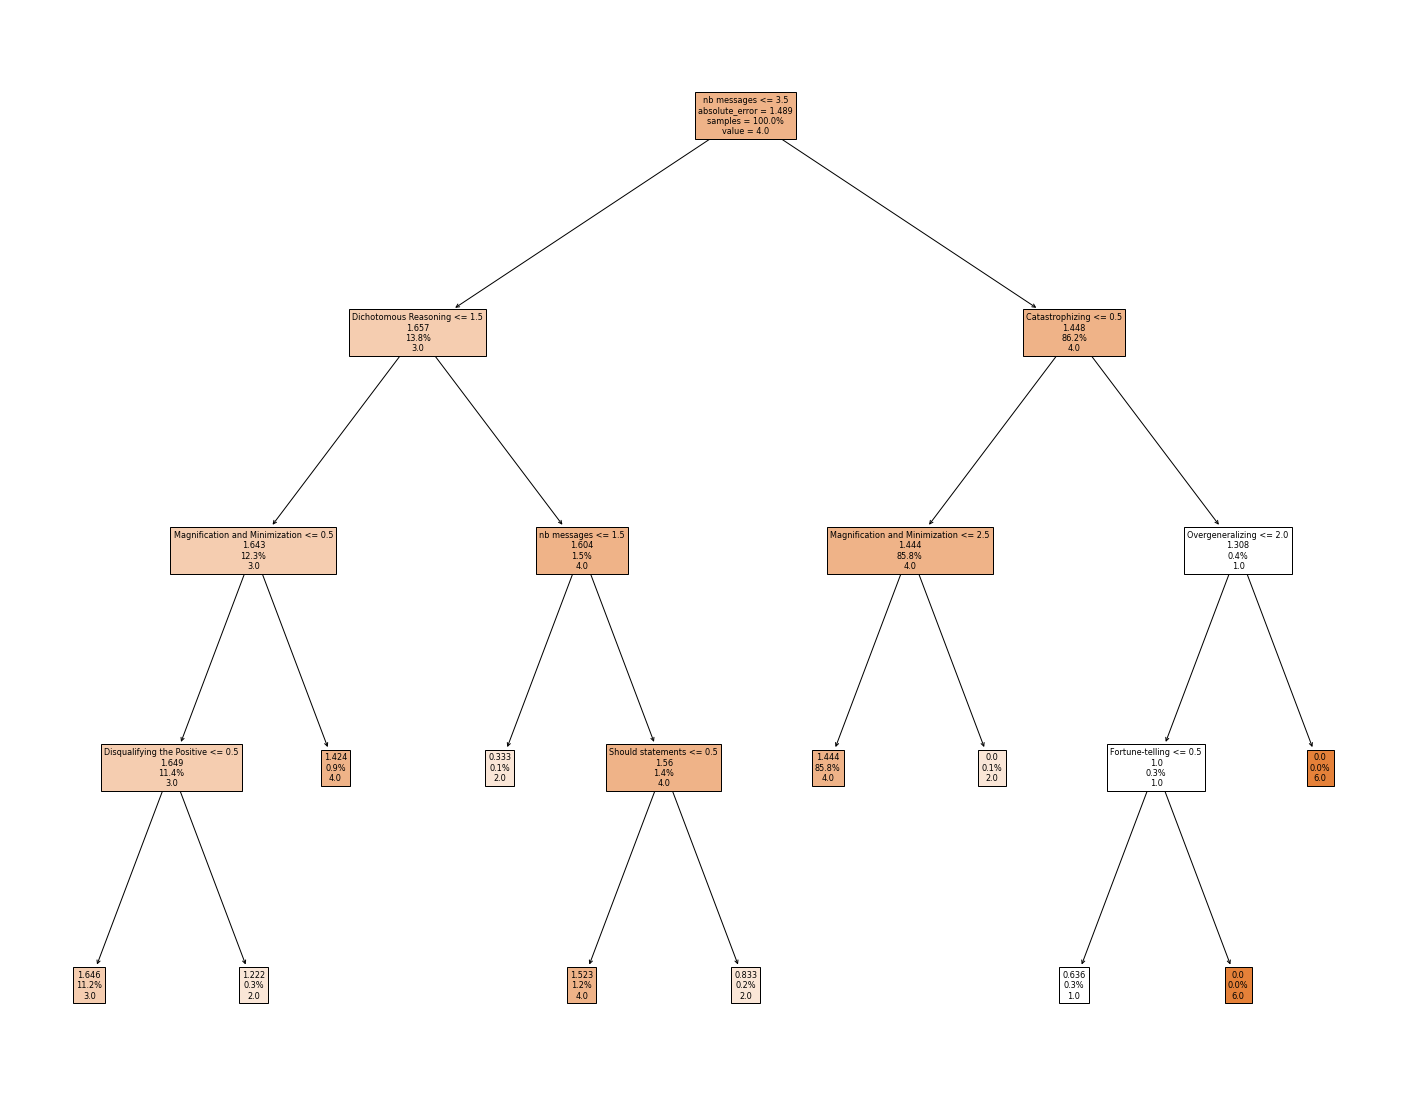

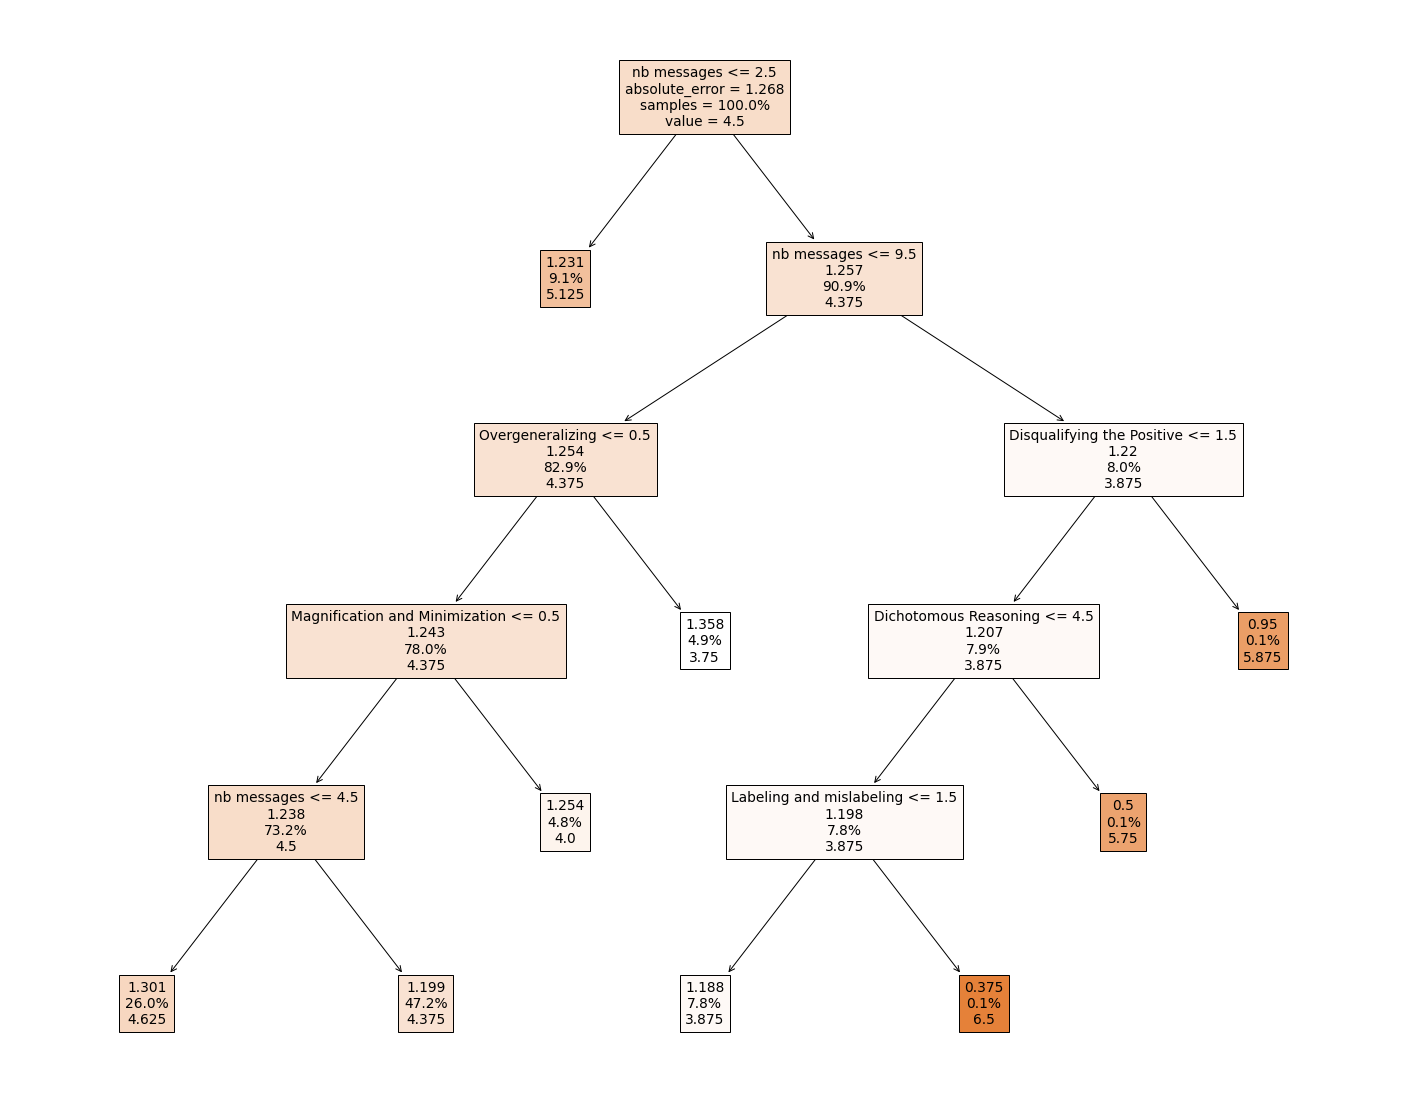

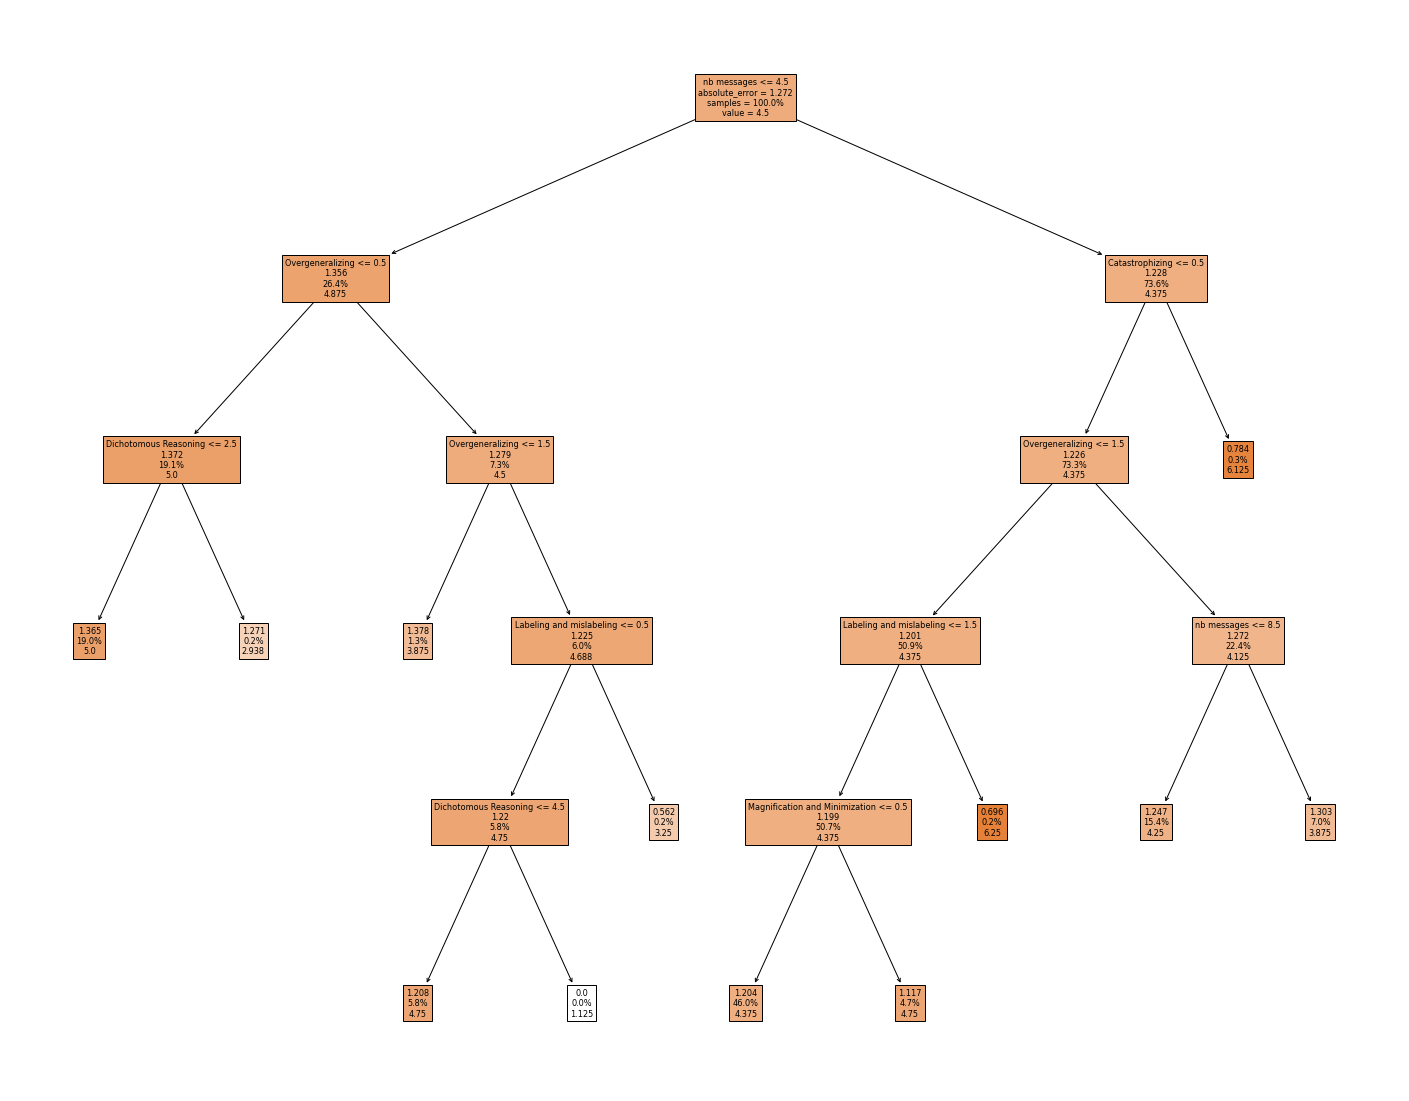

In [9]:
plot_tree(all_trees)         